Our data is in folder data/jena_data/jena_climate_2009_2016.csv

In [187]:
import pandas as pd
import numpy as np
datafile = "../data/jena_data/jena_climate_2009_2016.csv"

In [188]:
df = pd.read_csv(datafile)

In [189]:
print("data shape:", df.shape)
df.head()

data shape: (420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [152]:
print(df.isnull().values.any())
print(df.isna().values.any())
print(df.isin([0]).values.any())

# Replace inf with nans, and then find nans :)
# df.info()
# df.replace([np.inf, -np.inf], np.nan)
# df.info()

df.isnull().values.any()

False
False
True


False

In [190]:
df.drop("Date Time", axis=1, inplace=True)

In [191]:
# Take the temperature column as target data, convert it to numpy array
targets = df['T (degC)'].values
# convert the dataframe into a numpy matrix called `data`
data = df.values

The data contains measurements done each 10 minutes, so there are 144 measurements in a day. We can define the following parameters of the model:
- lookback = 1440 - we'll take data of last 10 days as direct input to the model
- steps = 6 - we won't use all data points since many features don't change much in less then an hour. We'll sample data using steps of 1 hour 
- delay = 144 - how further in the future we'd like to predict (24 hours)

In [192]:
lookback = 1440
steps = 6
delay = 144

In [193]:
train_samples = 200000
val_samples = 100000
# test samples would take the rest of data (or 120551 data rows)

Since the values of different features are spread across different ranges (eg. T is in the tens, and rho in the thousands), we need to normalize and standardize the data - subtract the mean and divide with the standard deviation of data. Here, the mean and st. dev are calculated only on the training set, but applied to the whole data.

In [194]:
mean = data[:train_samples].mean(axis=0)
data -= mean
std = data[:train_samples].std(axis=0)
data /= std

print(std)

# print 2 lines of the processed data
print(data[:2, :])

[ 8.48043388  8.85249908  8.95324185  7.16584991 16.72731652  7.68914559
  4.19808168  4.84034436  2.66564926  4.25206364 42.48884277  1.53666449
  2.33067298 86.61322998]
[[ 0.90014748 -1.93135845 -1.98211036 -1.86280029  1.07285236 -1.30742164
  -1.47375773 -0.79868641 -1.4762674  -1.47815522  2.12375056 -0.72950452
  -0.78067973 -0.27613603]
 [ 0.9060434  -1.97541381 -2.02567    -1.91582958  1.07883061 -1.32042698
  -1.4951961  -0.80075238 -1.49502455 -1.49932141  2.17199852 -0.93124017
  -0.88794488 -0.46317443]]


In [104]:
data.shape

(420551, 14)

Now we can define a Python generator function that will take as input our data and output batches of data, in the suitable format (batch_size, timesteps, num_features) to be inserted in the model. 

In [195]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while True:
        
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            # If we reached the end, start from beginning - to allow us to go through the data many times
            if i + batch_size > max_index:
                i = min_index + lookback
            # make sure you don't go over the length of data
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        # output format: (batch_size, timesteps, num_features)
        samples = np.zeros((len(rows), lookback // step, data.shape[1]))
        targets = np.zeros((len(rows),))
        
        # loop over a batch and create samples and targets
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

The above generator function can now be used to generate the train, validation and test datasets. It would generate samples forever, so in the `fit_generator` method below, we'd need to give values for the number of iterations to use, using the `steps_per_epoch` and `validation_steps` attributes.

There are a few problems I encountered in this part:
- First, the generator code in Cholet's book (see reference) seems to have a problem for the no-shuffling case. I think my fix in the above method is working well.
- Another (bigger issue) is connected to the validation generator which outputs `nan` values after a certain sample is reached. This problem is usually present if `inf` or `nan` values are present in the data, which was not the case for me. People on github suggest to use a different optimizer, like Adam, but this also doesn't help. I assume that the problem is due to some value in the data is equal to 0, so the optimizer at some point makes a division by 0. Therefore I tried normalizing / standardizing the data, not around 0 mean and 1 standard deviation, but in the range [0,1]. 
- A third issue is connected with the selection of the values for `steps_per_epoch` and `validation_steps` in the `fit_generator` method. The right way for this to be done I guess is setting them to a value: `num_samples / batch_size`, so that the whole dataset can be seen. A common mistake is to set these parameters to very large values (eg. the total number of samples in the train / val set) and then an epoch would take too long, so remember to divide by the batch_size.

Another important thing learned from the generator function above is how to shuffle timeseries data in order not to include infromation from the future to predict the past. 

In [205]:
batch_size = 128

train_gen = generator(data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=train_samples,
                     shuffle=True,
                     step=steps,
                     batch_size=batch_size)

val_gen = generator(data,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_samples + 1,
                    max_index=train_samples + val_samples,
                    shuffle=False,
                    step=steps,
                    batch_size=batch_size)

test_gen = generator(data,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_samples + val_samples + 1,
                    max_index=None,
                    shuffle=False,
                    step=steps,
                    batch_size=batch_size)

The below method `evaluate_baselie` is used to calculate a baseline for the problem. We assume that the temperature 24 hours from the current time would be same as the current one. We calculate the mean absolute error (MAE) using this approach, which is then directly comparable with the output of the model. The MAE for the temperature, using this approach, is around 2.5 celsius degrees, which means this is the average absolute error we'd do with this approach.

Our ML model must try to beat this baseline, which might not always be easy!

In [166]:
def evaluate_baseline():
    batch_maes = []
    
    # Loop the number of times needed to see the whole validation dataset
    val_steps = (train_samples + val_samples - train_samples - lookback - 1) // batch_size + 1
    print("# Validation steps:", val_steps)
    for i in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)
    
baseline_error = evaluate_baseline()
print('MAE for baseline approach: %.3f celsius degrees' %  (baseline_error * std[1]))

# Validation steps: 770
MAE for baseline approach: 2.572 celsius degrees


In [172]:
# Train steps to take in order to see the entire training set
train_steps = (train_samples - lookback) // batch_size + 1
# Number of steps to see the entire validation set
val_steps = (train_samples + val_samples - train_samples - lookback - 1) // batch_size + 1
# Number of steps to see the entire test set
test_steps = (len(data) - train_samples - val_samples - lookback - 1)  // batch_size + 1

print('train_steps:', train_steps)
print('val_steps:', val_steps)
print('test_steps:', test_steps)

# Build the model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
# We need to flatten the data which is generated to suit a recurrent model
model.add(layers.Flatten(input_shape=(lookback // steps, data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch = train_steps,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

train_steps: 1552
val_steps: 770
test_steps: 931
Epoch 1/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.3184 - val_loss: 0.3253
Epoch 2/20
1552/1552 [==============================] - 25s 16ms/step - loss: 0.1967 - val_loss: 0.3339
Epoch 3/20
1552/1552 [==============================] - 25s 16ms/step - loss: 0.1728 - val_loss: 0.3452
Epoch 4/20
1552/1552 [==============================] - 25s 16ms/step - loss: 0.1605 - val_loss: 0.3454
Epoch 5/20
1552/1552 [==============================] - 25s 16ms/step - loss: 0.1488 - val_loss: 0.3544
Epoch 6/20
1552/1552 [==============================] - 25s 16ms/step - loss: 0.1406 - val_loss: 0.3605
Epoch 7/20
1552/1552 [==============================] - 25s 16ms/step - loss: 0.1334 - val_loss: 0.3641
Epoch 8/20
1552/1552 [==============================] - 25s 16ms/step - loss: 0.1272 - val_loss: 0.3687
Epoch 9/20
1552/1552 [==============================] - 25s 16ms/step - loss: 0.1231 - val_loss: 0.3609
Epoch 10/20
155

In [197]:
def plot_history(history):
    """
    Plots the history of a model training - its loss and accuracy.
    """    
    import matplotlib.pyplot as plt
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

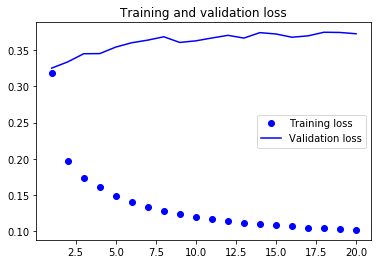

In [173]:
plot_history(history)

Ok the performance of our first model using a standard fully-connected network is far from the performance of the baseline case. The model is not capable of learning a simple pattern such as predicting a value 24 hours in the future, same as the current one. Parameter learning can sometimes fail to learn a simple solution to a simple problem.

Next, I can try using a recurrent network with GRU units on the same problem.

In [181]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

num_features = data.shape[1]  # 14 in this case

model = Sequential()
# why isn't there a `timesteps` dimension in the input_shape?
model.add(layers.GRU(32, input_shape=(None, num_features)))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, # use less steps than needed
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 76s 152ms/step - loss: 0.3126 - val_loss: 0.2702
Epoch 2/20
500/500 [==============================] - 74s 148ms/step - loss: 0.2847 - val_loss: 0.2634
Epoch 3/20
500/500 [==============================] - 74s 148ms/step - loss: 0.2778 - val_loss: 0.2642
Epoch 4/20
500/500 [==============================] - 74s 147ms/step - loss: 0.2711 - val_loss: 0.2662
Epoch 5/20
500/500 [==============================] - 74s 148ms/step - loss: 0.2653 - val_loss: 0.2717
Epoch 6/20
500/500 [==============================] - 75s 150ms/step - loss: 0.2600 - val_loss: 0.2653
Epoch 7/20
500/500 [==============================] - 74s 148ms/step - loss: 0.2558 - val_loss: 0.2708
Epoch 8/20
500/500 [==============================] - 74s 148ms/step - loss: 0.2513 - val_loss: 0.2647
Epoch 9/20
500/500 [==============================] - 74s 148ms/step - loss: 0.2480 - val_loss: 0.2676
Epoch 10/20
500/500 [==============================] - 73s 147ms/step - l

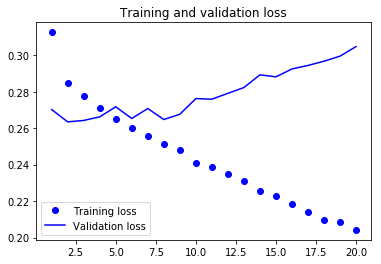

In [182]:
plot_history(history)

In [183]:
num_features = data.shape[1]  # 14 in this case

model_drop = Sequential()
# Why isn't there an activation here?
model_drop.add(layers.GRU(32, 
                          dropout=0.1,
                          recurrent_dropout=0.5,
                          return_sequences=True,
                          input_shape=(None, num_features)))
model_drop.add(layers.GRU(64,
                          activation='relu',
                          dropout=0.1,
                          recurrent_dropout=0.5))
model_drop.add(layers.Dense(1))

model_drop.compile(optimizer=RMSprop(), loss='mae')
history_drop = model.fit_generator(train_gen,
                                   steps_per_epoch=500,
                                   epochs=40,
                                   validation_data=val_gen,
                                   validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 77s 153ms/step - loss: 0.2001 - val_loss: 0.3038
Epoch 2/40
500/500 [==============================] - 76s 153ms/step - loss: 0.1975 - val_loss: 0.3076
Epoch 3/40
500/500 [==============================] - 76s 153ms/step - loss: 0.1944 - val_loss: 0.3109
Epoch 4/40
500/500 [==============================] - 76s 152ms/step - loss: 0.1918 - val_loss: 0.3128
Epoch 5/40
500/500 [==============================] - 77s 154ms/step - loss: 0.1886 - val_loss: 0.3150
Epoch 6/40
500/500 [==============================] - 87s 175ms/step - loss: 0.1867 - val_loss: 0.3172
Epoch 7/40
500/500 [==============================] - 78s 156ms/step - loss: 0.1852 - val_loss: 0.3135
Epoch 8/40
500/500 [==============================] - 88s 175ms/step - loss: 0.1822 - val_loss: 0.3173
Epoch 9/40
500/500 [==============================] - 86s 172ms/step - loss: 0.1810 - val_loss: 0.3182
Epoch 10/40
500/500 [==============================] - 101s 202ms/step - 

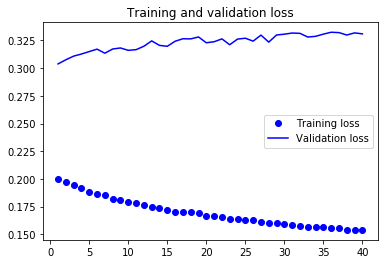

In [184]:
plot_history(history_drop)

In [206]:
num_features = data.shape[1]  # 14 in this case
del model_drop

model_drop = Sequential()
# Why isn't there an activation here?
model_drop.add(layers.GRU(32, 
                          dropout=0.1,
                          recurrent_dropout=0.5,
                          return_sequences=True,
                          input_shape=(None, num_features)))
model_drop.add(layers.GRU(64,
                          activation='relu',
                          dropout=0.1,
                          recurrent_dropout=0.5))
model_drop.add(layers.Dense(1))

model_drop.compile(optimizer=RMSprop(), loss='mae')
history_drop = model.fit_generator(train_gen,
                                   steps_per_epoch=500,
                                   epochs=40,
                                   validation_data=val_gen,
                                   validation_steps=val_steps)

Epoch 1/40
 29/500 [>.............................] - ETA: 1:12 - loss: 0.1248

KeyboardInterrupt: 

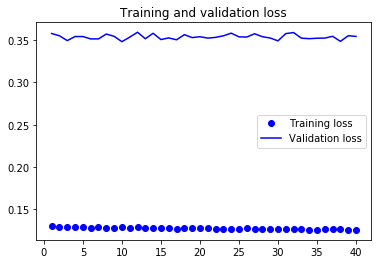

In [204]:
plot_history(history_drop)